In [1]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'cmpt-756-akash'
!gcloud config set project {project_id}

Updated property [core/project].


In [1]:
# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://news_csv/train.csv /tmp/
!gsutil cp gs://news_csv/fake.csv /tmp/
!gsutil cp gs://news_csv/fake_or_real_news.csv /tmp/
!gsutil cp -r gs://news_csv/fake-news/ /tmp/
!gsutil cp -r gs://news_csv/fakenewskdd2020/ /tmp/
# # Print the result to make sure the transfer worked.
# !cat /tmp/

Copying gs://news_csv/train.csv...
/ [1 files][112.6 MiB/112.6 MiB]                                                
Operation completed over 1 objects/112.6 MiB.                                    
Copying gs://news_csv/fake.csv...
- [1 files][ 54.0 MiB/ 54.0 MiB]                                                
Operation completed over 1 objects/54.0 MiB.                                     
Copying gs://news_csv/fake_or_real_news.csv...
- [1 files][ 29.3 MiB/ 29.3 MiB]                                                
Operation completed over 1 objects/29.3 MiB.                                     
Copying gs://news_csv/fake-news/test.csv...
Copying gs://news_csv/fake-news/train.csv...
| [2 files][118.0 MiB/118.0 MiB]                                                
Operation completed over 2 objects/118.0 MiB.                                    
Copying gs://news_csv/fakenewskdd2020/test.csv...
Copying gs://news_csv/fakenewskdd2020/train.csv...
\ [2 files][ 23.5 MiB/ 23.5 MiB]          

In [1]:
# !pip install -q -U keras-tuner
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
from pickle import load
from numpy import asarray
import datetime
from numpy import zeros
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from kerastuner import RandomSearch, BayesianOptimization
from tensorflow.keras.applications import ResNet50

In [ ]:
df = pd.read_csv("/tmp/fake.csv")

# list of language values to drop
drop_lang_values = ['ignore', 'german', 'french', 'spanish', 'russian',
       'greek', 'finnish', 'portuguese', 'arabic', 'dutch', 'italian',
       'turkish', 'norwegian', 'chinese', 'polish']

df = df[~df.language.isin(drop_lang_values)]
df.language.unique() # shows the number of unique language column values to check if only en is left 

# list of columns to drop
df = df.drop(columns=['uuid', 'ord_in_thread', 'published', 'crawled', 'thread_title', 
                      'spam_score', 'main_img_url', 'replies_count', 'participants_count',	
                      'likes', 'comments', 'shares', 'country',	'domain_rank', 'language', 'title', 'author', 'site_url'])

df.type.unique() # number of classes we have

In [ ]:
df.type.value_counts()

bs            10900
bias            443
conspiracy      430
hate            243
satire          146
state           120
junksci         102
fake             19
Name: type, dtype: int64

Clearly we can see that we have a lot of classes and they are not balanced. So, we need to do something to balance the dataset first.

To fix the imbalanced dataset, we are going to reduce the classes to two only.

In [ ]:
# dropna and reindex
df = df.dropna()
df_new = df.reindex()

df_new.loc[df_new['type'] == 'bias', 'type'] = 'bias, conspiracy, hate, satire, state, junksci or fake'
df_new.loc[df_new['type'] == 'conspiracy', 'type'] = 'bias, conspiracy, hate, satire, state, junksci or fake'
df_new.loc[df_new['type'] == 'hate', 'type'] = 'bias, conspiracy, hate, satire, state, junksci or fake'
df_new.loc[df_new['type'] == 'satire', 'type'] = 'bias, conspiracy, hate, satire, state, junksci or fake'
df_new.loc[df_new['type'] == 'state', 'type'] = 'bias, conspiracy, hate, satire, state, junksci or fake'
df_new.loc[df_new['type'] == 'junksci', 'type'] = 'bias, conspiracy, hate, satire, state, junksci or fake'
df_new.loc[df_new['type'] == 'fake', 'type'] = 'bias, conspiracy, hate, satire, state, junksci or fake'

In [ ]:
df_new.type.value_counts()

bs                                                        10900
bias, conspiracy, hate, satire, state, junksci or fake     1457
Name: type, dtype: int64

In [2]:
# Second Dataset
df_2 = pd.read_csv('/tmp/fake_or_real_news.csv')
# drop unrequired columns and rename.
df_2 = df_2.drop(columns=['title', 'Unnamed: 0']).dropna().reindex()
df_2 = df_2.rename(columns={'label':'type'})
# df_final = df_2

In [15]:
df_2.type.value_counts()

REAL    3171
FAKE    3164
Name: type, dtype: int64

In [3]:
# Third dataset
# Labels are:
# 1: fake
# 0: true
df_3 = pd.read_csv('/tmp/fakenewskdd2020/train.csv', delimiter="\t", quoting=csv.QUOTE_NONE)
df_3 = df_3.rename(columns={'label':'type'}).dropna().reindex()

# label classes
df_3.loc[df_3['type'] == '1', 'type'] = 'FAKE'
df_3.loc[df_3['type'] == '0', 'type'] = 'REAL'

# drop label column
drop_val = ['label']
df_3 = df_3[~df_3.type.isin(drop_val)]

df_3.type.value_counts()

REAL    2973
FAKE    2014
Name: type, dtype: int64

In [23]:
df_final = df_3

In [4]:
# Fourth Dataset 
# Labels are:
# 1: unreliable
# 0: reliable

df_4 = pd.read_csv('/tmp/fake-news/train.csv')
df_4 = df_4.rename(columns={'label':'type'}).drop(columns=['id', 'title', 'author']).dropna().reindex()
df_4['label'] = np.where(df_4.type == 1, "FAKE", "REAL")
df_4 = df_4.drop(columns=['type']).rename(columns={'label':'type'})
df_4.type.value_counts()

REAL    10387
FAKE    10374
Name: type, dtype: int64

In [14]:
df_final = df_4

Combine all of the datasets and check if the final dataset is balanced.

In [15]:
df_final = df_2.append([df_3, df_4]).reindex()
df_final.type.value_counts()

REAL    16531
FAKE    15552
Name: type, dtype: int64

So, our dataset is pretty much balanced and now, we can use this dataset.

Text dataset requires a lot of cleaning to reduce the noise and increase the presence of meaningful words. We are going to do some cleaning like:
1. Lowercase all words.
2. Filter out punctuations.
3. Remove words that are not alphabetic. 
4. Remove stop words.
5. Remove Stem words.
6. Remove words that are of length 1.



Need to work on lower case

In [6]:
import string
import re
import nltk
import pandas as pd
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def clean_text(text):
    # split into words
    # tokens = word_tokenize(text)
    # convert to lower case
    tokens = text.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # print(words[:100])
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    # print(stemmed[:100])
    # filter out short tokens
    cleaned_words = [word for word in stemmed if len(word) > 1]
    return cleaned_words

df_final['text'] = df_final.text.apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df_final.head()

,text,type
0,"[daniel, greenfield, shillman, journal, fellow...",FAKE
1,"[googl, pinterest, digg, linkedin, reddit, stu...",FAKE
2,"[US, secretari, state, john, kerri, said, mond...",REAL
3,"[kayde, king, kaydeek, novemb, the, lesson, to...",FAKE
4,"[it, primari, day, new, york, frontrunn, hilla...",REAL


In [ ]:
df_final.to_csv('cleaned.csv') # saving to file 

In [ ]:
!gsutil cp cleaned.csv gs://news_csv/ # saving to bucket

CommandException: No URLs matched: cleaned.csv


In [ ]:
!gsutil cp gs://news_csv/cleaned.csv /tmp/ # load from bucket
df_final = pd.read_csv('/tmp/cleaned.csv') 
df_final = df_final.sample(frac=1).reset_index(drop=True) # shuffle the data
df_final.head()

Copying gs://news_csv/cleaned.csv...
| [1 files][159.6 MiB/159.6 MiB]                                                
Operation completed over 1 objects/159.6 MiB.                                    


,Unnamed: 0,text,type
0,9209,"['counter', 'coup', 'with', 'counter', 'coup',...",bs
1,897,"['fastaqim', 'posit', 'overrun', 'fighter', 'd...",bs
2,2431,"['russia', 'ha', 'call', 'war', 'parti', 'bluf...",FAKE
3,2481,"['post', 'octob', 'ryan', 'banist', 'project',...",bs
4,4315,"['comment', 'crosstalk', 'US', 'elect', 'crimi...",FAKE


In [7]:
# integer encode the documents
def create_tokenizer(lines):
    tokenizer = Tokenizer(lower=True)
    tokenizer.fit_on_texts(lines)
    return tokenizer


# integer encode and pad documents
def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

tokenizer = create_tokenizer(df_final['text'].values)
vocab_size = len(tokenizer.word_index) + 1
# max_length = max([len(d.split()) for d in df_final['text'].values])
train_data = encode_docs(tokenizer, 400, df_final['text'].values)

Word Embedding of train data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


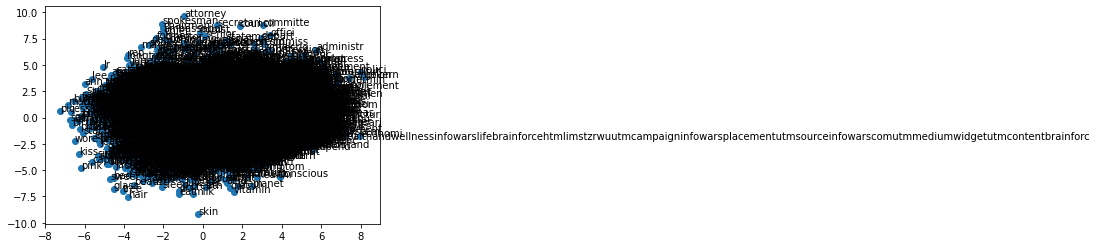

In [47]:
# plot word embedding vector using scatter plot in 2d using PCA to reduce the dimensions 

from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
# train model
model = Word2Vec(df_final['text'].values, min_count=100)
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [14]:
# extract trained model weight files
!gsutil cp -r gs://news_csv/glove.twitter.27B/ /tmp/ 

Copying gs://news_csv/glove.twitter.27B/glove.twitter.27B.100d.txt...
Copying gs://news_csv/glove.twitter.27B/glove.twitter.27B.200d.txt...
Copying gs://news_csv/glove.twitter.27B/glove.twitter.27B.25d.txt...
Copying gs://news_csv/glove.twitter.27B/glove.twitter.27B.50d.txt...
\ [4 files][  3.6 GiB/  3.6 GiB]  107.7 MiB/s                                   
Operation completed over 4 objects/3.6 GiB.                                      


In [7]:
# Load Stanford's GloVe Embedding
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
glove_input_file = '/tmp/glove.twitter.27B/glove.twitter.27B.200d.txt'
word2vec_output_file = 'glove.twitter.27B.200d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
# load the converted model
# filename = 'glove.twitter.27B.200d.txt.word2vec'
# model = KeyedVectors.load_word2vec_format(filename, binary=False)
# # calculate: (king - man) + woman = ?
# result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
# print(result)

(1193514, 200)

We can see above, the woman + king - man = queen. Word Embeddings understand this co-relation between different words. 

In [8]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.twitter.27B.200d.txt.word2vec', mode='rt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

# It is pretty slow to load weights of all the words from embedding into memory. Instead, 
# we can load the weights of words that are represent in out text 
embedding_matrix = zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word[1:-1])
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        # print(embedding_matrix[i])

##Define Models

Model 1:
Pre-trained model Embedding + LSTM + Dense

In [9]:
def first_model(vocab_size, max_length, embedding_matrix):
    model = Sequential()
    # model.add(Embedding(vocab_size, 50, input_length=300))
    model.add(Embedding(embedding_matrix.shape[0], 200, weights=[embedding_matrix], input_length=400, trainable=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(50))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(df_final.type.unique()), activation='softmax'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

Model 2: ResNet50 pre-trained + LSTM + Dense

In [ ]:
# def second_model(vocab_size, max_length):
#     model = Sequential()
#     # model.add(Embedding(vocab_size, 100, input_length=400))
#     model.add(ResNet50(include_top=False, weights=embedding_matrix, pooling=None))
#     model.add(LSTM(200))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(len(df_final.type.unique()), activation='softmax'))
#     # compile network
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize defined model
#     model.summary()
#     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

Model 3: Hyperparameter tuning with kerastuner and model structure is Embedding with pre-trained twitter.27B.200d + LSTM + Drouput + Dense

In [ ]:
# def third_model(hp):

#     activation = hp.Choice('activation', ['relu', 'tanh'])
#     dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.2)

#     model = Sequential()
#     e = Embedding(189412, 200, weights=[embedding_matrix], input_length=400, trainable=True)
#     model.add(e)
#     # model.add(Flatten())
#     hp_units1 = hp.Int('units', min_value=32, max_value=128, step=16)
#     model.add(LSTM(units=hp_units1))
#     model.add(Dropout(0.5))
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=128, step=16)
#     model.add(Dense(units=hp_units, activation=activation))
#     model.add(Dense(64, activation=activation))
#     model.add(Dense(len(df_final.type.unique()), activation='softmax'))

#     lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
#     decay_rate = hp.Choice('decay_rate', [0.90, 0.60, 0.30, 0.10])
#     # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr, decay_rate=decay_rate, decay_steps = tr_decay/tr_data.batch_size, staircase=True)

#     # compile the model
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model


# MAX_TRAILS = 30
# batch_size = 32
# epochs = 10
# seed = 40

# # change the first parameter according to the network you want to train. 
# tuner = RandomSearch(third_model,
#                      objective='val_accuracy',
#                      max_trials=MAX_TRAILS,
#                      seed=seed,
#                      overwrite=True
#                      )

# print("Search space summary:\n {}".format(tuner.search_space_summary()))
# print("Searching starting >>> started")

# %cd /tmp/
# !mkdir -p pre-trained-embedding
# dir = '/tmp/pre-trained-embedding/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# X = train_data
# # print(X)
# Y = pd.get_dummies(df_final['type']).values
# tuner.search(X, Y, epochs=epochs, validation_split=0.2, callbacks=[stop_early])

# print("Results summary:\n {}".format(tuner.results_summary()))
# print("Top 10 best models:\n {}".format(tuner.get_best_models(10)))

# best_hyperparameters = tuner.get_best_hyperparameters(num_trials = 1)[0]
# best_model = tuner.hypermodel.build(best_hyperparameters)

# best_model.save('/tmp/kerastuner/model/') # save to tmp
# !gsutil cp -r /tmp/kerastuner/model/ gs://news_csv/model # save to bucket 
# !gsutil cp -r gs://news_csv/model /tmp/ # load from bucket

In [ ]:
# Word Embeddings + CNN = Text Classication

# def fourth_model(vocab_size, max_length):
# model = Sequential()
# model.add(Embedding(vocab_size, 100, input_length=400))
# model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # compile network
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # summarize defined model
# model.summary()
# plot_model(model, to_file='model.png', show_shapes=True)
# return model


# # n-gram CNN

# def fifth_model(length, vocab_size):
#     # channel 1
#     inputs1 = Input(shape=(400,))
#     embedding1 = Embedding(vocab_size, 100)(inputs1)
#     conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
#     drop1 = Dropout(0.5)(conv1)
#     pool1 = MaxPooling1D(pool_size=2)(drop1)
#     flat1 = Flatten()(pool1)
#     # channel 2
#     inputs2 = Input(shape=(400,))
#     embedding2 = Embedding(vocab_size, 100)(inputs2)
#     conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
#     drop2 = Dropout(0.5)(conv2)
#     pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)
#     # channel 3
#     inputs3 = Input(shape=(400,))
#     embedding3 = Embedding(vocab_size, 100)(inputs3)
#     conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
#     drop3 = Dropout(0.5)(conv3)
#     pool3 = MaxPooling1D(pool_size=2)(drop3)
#     flat3 = Flatten()(pool3)
#     # merge
#     merged = concatenate([flat1, flat2, flat3])
#     # interpretation
#     dense1 = Dense(10, activation='relu')(merged)
#     outputs = Dense(1, activation='sigmoid')(dense1)
#     model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
#     # compile
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     # summarize
#     model.summary()
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
#     return model

Fit the model to data

In [10]:
# Seperate the dataset into train and test

X = train_data
Y = pd.get_dummies(df_final['type']).values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, shuffle=True)

In [11]:
# fit the model 
model = first_model(vocab_size, 400, embedding_matrix)
# model = load_model('/tmp/model/') # if you want to run third model
history = model.fit(x_train, y_train, verbose=1, batch_size=32, epochs=15)

!mkdir -p saved_model
model.save('saved_model/first_model/')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 200)          36939800  
_________________________________________________________________
lstm (LSTM)                  (None, 400, 100)          120400    
_________________________________________________________________
dropout (Dropout)            (None, 400, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

INFO:tensorflow:Assets written to: saved_model/first_model/assets


INFO:tensorflow:Assets written to: saved_model/first_model/assets


dict_keys(['loss', 'accuracy'])


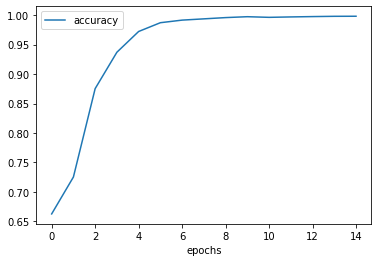

In [12]:
# plot the history of training 
print(history.history.keys())
import matplotlib.pyplot as plt
# plt.title('Loss')
# plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(['accuracy'], loc='upper left')
plt.xlabel("epochs")
plt.show()

In [13]:
new_model = load_model('saved_model/first_model/')

new_model.summary()

loss, acc = new_model.evaluate(x_test, y_test, verbose=1, batch_size=32)
print("LOSS: {} \nACC: {}".format(loss, acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 200)          36939800  
_________________________________________________________________
lstm (LSTM)                  (None, 400, 100)          120400    
_________________________________________________________________
dropout (Dropout)            (None, 400, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [14]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
y_pred = new_model.predict_classes(x_test, batch_size=32, verbose=1)

y_hat = np.argmax(y_test, axis=1)
print("confusion matrix")
print(confusion_matrix(y_hat, y_pred))
print("0: Fake\n1: Real")
print(classification_report(y_hat, y_pred, labels=[0,1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


201/201 [==============================] - 4s 17ms/step
confusion matrix
[[2746  357]
 [ 257 3057]]
0: Fake
1: Real
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3103
           1       0.90      0.92      0.91      3314

    accuracy                           0.90      6417
   macro avg       0.90      0.90      0.90      6417
weighted avg       0.90      0.90      0.90      6417



Using AYLIEN API to download the present news data. It only downloads 10 news at each run, so we have to run it multiple times changing the time range. 

I looked for most frequent words in the top **1000** rows of dataset and then used those words to extract present news.

To extract the Most common words in the text, I used spacy name entity. 



In [16]:
# NOTE: to run this cell, first run the df_final variable cell up again as it requres the raw text data.
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")
count = Counter()
for x, value in df_final['text'][:500].iteritems():
    doc = nlp(value)
    #  if token.label_ is PERSON or token.label_ is NORP or token.label_ is ORG or token.label_ is PRODUCT or token.label_ is LAW
    entities = [token.text for token in doc.ents  if token.label_ is "PERSON" or token.label_ is "NORP" or token.label_ is "ORG" or token.label_ is "PRODUCT" or token.label_ is "LAW"]
    count.update(entities)
    # print(entities)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [17]:
count.most_common()

[('Trump', 1256),
 ('Clinton', 1144),
 ('Republican', 404),
 ('Donald Trump', 366),
 ('Hillary Clinton', 353),
 ('Republicans', 320),
 ('American', 287),
 ('Democrats', 280),
 ('Obama', 280),
 ('Americans', 264),
 ('FBI', 246),
 ('Democratic', 240),
 ('ISIS', 239),
 ('Sanders', 233),
 ('Congress', 222),
 ('GOP', 211),
 ('Hillary', 193),
 ('Senate', 180),
 ('Cruz', 174),
 ('Lesley Stahl', 144),
 ('Bush', 135),
 ('House', 134),
 ('CNN', 123),
 ('Rubio', 95),
 ('Russian', 94),
 ('Fox News', 84),
 ('Syrian', 80),
 ('Comey', 78),
 ('the White House', 77),
 ('White House', 77),
 ('Democrat', 75),
 ('Ryan', 69),
 ('Bernie Sanders', 69),
 ('Islamic', 64),
 ('State', 63),
 ('Barack Obama', 63),
 ('Iraqi', 62),
 ('French', 61),
 ('Facebook', 61),
 ('the State Department', 60),
 ('Clintons', 59),
 ('Bill Clinton', 57),
 ('Ted Cruz', 56),
 ('Obamacare', 56),
 ('Muslim', 55),
 ('Putin', 50),
 ('Christians', 48),
 ('Jeb Bush', 48),
 ('the Supreme Court', 45),
 ('Iranian', 44),
 ('Muslims', 44),
 ('P

In [27]:
!pip install aylien-news-api==0.1.0
import aylien_news_api
from aylien_news_api.rest import ApiException
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

# Configure API key authorization: app_id
aylien_news_api.configuration.api_key['X-AYLIEN-NewsAPI-Application-ID'] = 'd101abf6'
# Configure API key authorization: app_key
aylien_news_api.configuration.api_key['X-AYLIEN-NewsAPI-Application-Key'] = '288ff9adb9a7599664c21acc9f19481e'

# create an instance of the API class
api_instance = aylien_news_api.DefaultApi()

title = 'clinton'
language = ['en']
since = 'NOW-40DAYS'
until = 'NOW-20DAYS'

try:
    # List stories
    api_response = api_instance.list_stories(title=title, language=language, published_at_start=since, published_at_end=until)
except ApiException as e:
    print("Exception when calling DefaultApi->list_stories: %s\n" % e)

In [28]:
# present_news = [] # uncomment if you are running this cell for first time, comment for the second time to add 10 more news.
for i in api_response.stories:
    present_news.append([i.body])
print("Number of News extracted: {}".format(len(present_news)))


Number of News extracted: 20


In [29]:
tokenizer = create_tokenizer(present_news)
vocab_size = len(tokenizer.word_index) + 1
# max_length = max([len(d.split()) for d in df_final['text'].values])
present_data = encode_docs(tokenizer, 400, present_news)
y_pred = new_model.predict_classes(present_data, batch_size=32, verbose=1)
y_pred

1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])